<h1>Module 16 Project Template</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [29]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 0,
                "carriages": [],
                "current_status": "STOPPED_AT",
                "current_stop_sequence": 1,
                "direction_id": 0,
                "label": "1861",
                "latitude": 42.32981538,
                "longitude": -71.08409603,
                "occupancy_status": "FEW_SEATS_AVAILABLE",
                "revenue": "REVENUE",
                "speed": null,
                "updated_at": "2024-07-27T22:33:57-04:00"
            },
            "id": "y1861",
            "links": {
                "self": "/vehicles/y1861"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "64",
                        "type": "st

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [30]:
import os
import pymysql
import pandas as pd
import numpy as np

host = '127.0.0.1'
port = 3307
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses", conn)
df['updated_at'] = df['updated_at'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df
# df.tail(10)

C:\Users\andre\AppData\Local\Temp\ipykernel_40424\3390946885.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses", conn)


,record_num,id,latitude,longitude,occupancy_status,current_status,bikes_allowed,headsign,bearing,current_stop_sequence,updated_at
0,1,y3277,42.348192,-71.088809,FULL,STOPPED_AT,1,Harvard,351.0,13.0,2024-07-25 15:28:01-04:00
1,2,y3272,42.337255,-71.077769,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,140.0,17.0,2024-07-25 15:28:00-04:00
2,3,y3268,42.340720,-71.064160,MANY_SEATS_AVAILABLE,STOPPED_AT,1,Harvard,225.0,1.0,2024-07-25 15:27:56-04:00
3,4,y3265,42.348377,-71.088427,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,151.0,12.0,2024-07-25 15:27:58-04:00
4,5,y3264,42.336310,-71.076690,FEW_SEATS_AVAILABLE,STOPPED_AT,1,Harvard,315.0,8.0,2024-07-25 15:27:56-04:00
...,...,...,...,...,...,...,...,...,...,...,...
100973,100974,y1859,42.346617,-71.087415,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Harvard,332.0,13.0,2024-07-27 22:34:03-04:00
100974,100975,y1818,42.361236,-71.096897,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,155.0,9.0,2024-07-27 22:34:01-04:00
100975,100976,y1810,42.339046,-71.080324,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,150.0,16.0,2024-07-27 22:34:02-04:00
100976,100977,y1775,42.346015,-71.087093,MANY_SEATS_AVAILABLE,STOPPED_AT,1,Harvard,341.0,12.0,2024-07-27 22:34:02-04:00



The code below saves the data as a csv file to the local directory as a backup.

In [31]:

df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

In [32]:
def route_times_by_bus_id (bus_id):
    bus_df = df[(df['id'] == bus_id) & (df['current_status'] == 'STOPPED_AT')]
    # print('*********Example bus_df: ', bus_df)

    # remove duplicates
    bus_df = bus_df.drop_duplicates(subset="updated_at")
    bus_df.to_csv('bus_df.csv')

    # WARNING. tracking the bus from 1st stop to last doesn't account for the time it takes to get from the last back to the first.
    route_times = []
    time_at_first_current_stop_sequence = None
    current_stop_sequence = None
    first_current_stop_sequence = 1
    last_current_stop_sequence = 23
    start_latitude = None
    start_longitude = None
    for record in bus_df.to_dict(orient='records'):
        # print(record)
        # If the record is not from the same stop previously. Need this because bus could have multiple updates at the same stop
        if current_stop_sequence != record["current_stop_sequence"]:
            # when the bus shows it is at the first stop sequence
            if record['current_stop_sequence'] == first_current_stop_sequence:
                # If the record is not from the same stop previously. Need this because bus could have multiple updates at the same stop
                time_at_first_current_stop_sequence = record["updated_at"]
                start_latitude = record["latitude"]
                start_longitude = record["longitude"]
            # if the bus reached the end of the route, append the time,
            # AND if the bus was previously at the first stop sequence, so we know it made a complete lap
            # AND if it's the beginning of the day, don't append the time. Should probably have a better way to handle this. Maybe current_status has a status that says it's on break, actually that's what revenue is.
            elif (
                record["current_stop_sequence"] == last_current_stop_sequence 
                and time_at_first_current_stop_sequence 
                and (record["updated_at"] - time_at_first_current_stop_sequence < pd.Timedelta("0 days 02:00:00"))
            ):
                route_times.append(
                    {
                        "start_latitude": start_latitude,
                        "start_longitude": start_longitude,
                        "end_latitude": record["latitude"],
                        "end_longitude": record["longitude"],
                        "time_elapsed": record["updated_at"]
                        - time_at_first_current_stop_sequence,
                        "start_time": time_at_first_current_stop_sequence,
                        "bus_id": bus_id,
                    }
                )
        current_stop_sequence = record["current_stop_sequence"]

    return route_times

In [33]:
# get all the route times for all the buses

unique_bus_ids = df['id'].unique()
route_times_for_all_buses = []
for bus_id in unique_bus_ids:
    route_times = route_times_by_bus_id(bus_id)
    route_times_for_all_buses.extend(route_times)

# convert to pd.DataFrame
route_times_for_all_buses = pd.DataFrame(route_times_for_all_buses)
print('''*********Number of completed routes:\n''', len(route_times_for_all_buses))
# get the average route time
average_route_time = route_times_for_all_buses["time_elapsed"].mean()
print('*********average_route_time in minutes:\n {:.2f}'.format((average_route_time.total_seconds() / 60)))

*********Number of completed routes:
 323
*********average_route_time in minutes:
 45.55


<h1>Provide a Visualization based on the data</h1>

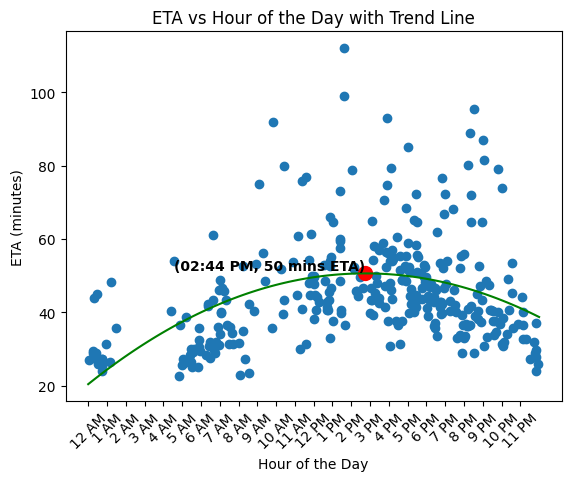

In [34]:
import datetime
import matplotlib.pyplot as plt

# Create a scatter plot
route_times_for_all_buses["seconds_in_day"] = route_times_for_all_buses["start_time"].dt.hour * 3600 + route_times_for_all_buses["start_time"].dt.minute * 60 + route_times_for_all_buses["start_time"].dt.second
route_times_for_all_buses = route_times_for_all_buses.sort_values(by="seconds_in_day",ascending=False) # needed or else trend line will be all over the place
plt.scatter(
    route_times_for_all_buses["seconds_in_day"],
    route_times_for_all_buses["time_elapsed"].dt.total_seconds() / 60,
)

# Fit a trend line. Maybe can also use sklearn.linear_model.LinearRegression? I think polyfit only does simple linear regression, meaning 1 x and 1 y.
fit = np.polyfit(route_times_for_all_buses["seconds_in_day"], route_times_for_all_buses["time_elapsed"].dt.total_seconds() / 60, 2) # 2 is the degree of the polynomial aka nonlinear quadratic regression, so it fits better than 1 which is a straight line aka simple linear regression. multiple regression is something else, having multiple independent x variables. If the degree is too high, it will overfit the data, meaning it won't generalize well to new data.
regression_line = np.poly1d(fit)


# Plot the trend line
x_trendline = np.linspace(0, 86400, 100) # 86400 seconds in a day. 100 is the number of points to generate equally spaced between 0 and 86400
# y_trendline = regression_line(x_trendline) # OR you could use polyval below
y_trendline = np.polyval(fit, x_trendline)
plt.plot(x_trendline, y_trendline, color="green")


# create a marker for the highest point on the trendline
coef = regression_line.coef
order = regression_line.order
max_x = -coef[1] / (2 * coef[0])
max_y = regression_line(max_x)
plt.scatter(max_x, max_y, s=100,c='red')
# Convert max_x to time format
max_x_time = datetime.timedelta(seconds=max_x)
max_x_time_in_ampm = (datetime.datetime.min + max_x_time).strftime("%I:%M %p")
# Add text to the plot
plt.text(
  max_x, max_y, f"({max_x_time_in_ampm}, {int(max_y)} mins ETA)", ha="right", va="bottom", weight="bold"
)


# Set the x-axis and y-axis labels
plt.xlabel("Hour of the Day")
plt.ylabel("ETA (minutes)")

# Set the x-axis ticks
plt.xticks(range(0, 86400, 3600), ['{} {}'.format((i // 3600) % 12 or 12, 'AM' if i // 43200 == 0 else 'PM') for i in range(0, 86400, 3600)], rotation=45)

# Set the title of the plot
plt.title("ETA vs Hour of the Day with Trend Line")

# Show the plot
plt.show()

<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [35]:
from haversine import haversine

def calculate_average_speed(row):
  start_latitude = row['start_latitude']
  start_longitude = row['start_longitude']
  end_latitude = row['end_latitude']
  end_longitude = row['end_longitude']

  distance = haversine((start_latitude, start_longitude), (end_latitude, end_longitude), unit='mi')
  
  time_elapsed = row['time_elapsed'].total_seconds() / 3600 # convert to hours
  average_speed = distance / time_elapsed
  return average_speed

route_times_for_all_buses['average_speed'] = route_times_for_all_buses.apply(calculate_average_speed, axis=1)
average_speed_all_route_times = route_times_for_all_buses['average_speed'].mean()

average_speed_all_route_times # miles per hour
print(
    f"""*********average_speed_all_route_times: {average_speed_all_route_times:.2f} miles per hour"""
)

*********average_speed_all_route_times: 4.80 miles per hour
